# RL Traveling Salesman

In this notebook, we implement a reinforcement learning approach to the traveling salesman problem. It is based on Q-learning and structure2vec graph embeddings.

In [1]:
import numpy as np
import torch
import random
import math
from collections import namedtuple
import os
import time

from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from scipy.signal import medfilt

""" Note: the code is not optimized for GPU
"""
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

In [2]:
!wget http://elib.zib.de/pub/mp-testdata/tsp/tsplib/tsp/ch130.tsp

--2021-05-27 15:30:34--  http://elib.zib.de/pub/mp-testdata/tsp/tsplib/tsp/ch130.tsp
Resolving elib.zib.de (elib.zib.de)... 130.73.108.67
Connecting to elib.zib.de (elib.zib.de)|130.73.108.67|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4386 (4.3K) [text/plain]
Saving to: ‘ch130.tsp’

ch130.tsp           100%[===================>]   4.28K  --.-KB/s    in 0.1s    

2021-05-27 15:30:35 (44.0 KB/s) - ‘ch130.tsp’ saved [4386/4386]



In [3]:
ch130 = open('ch130.tsp','r')
tsp_data = ch130.read()
cord = [list(map(float,i.split())) for i in tsp_data.split('\n')[6:-2]]
cord = np.array(cord)[:,1:]

In [4]:
matrix = distance_matrix(cord, cord)

## Create Graph Instances
Below we implement a small method to generate random graph instances.

In [5]:
def get_graph_mat(n=20):
    """ Throws n nodes uniformly at random on a square, and build a (fully connected) graph.
        Returns the (N, 2) coordinates matrix, and the (N, N) matrix containing pairwise euclidean distances.
    """
    coords = np.random.randint(0,10000,size=(n,2))
    dist_mat = distance_matrix(coords, coords)
    return coords, dist_mat

def plot_graph(coords):
    """ Utility function to plot the fully connected graph
    """
    n = len(coords)
    
    plt.figure(figsize=(9,9))
    plt.scatter(coords[:,0], coords[:,1], s=[50 for _ in range(n)])
    for i in range(n):
        for j in range(n):
            if j < i:
                plt.plot([coords[i,0], coords[j,0]], [coords[i,1], coords[j,1]], 'b', alpha=0.5)

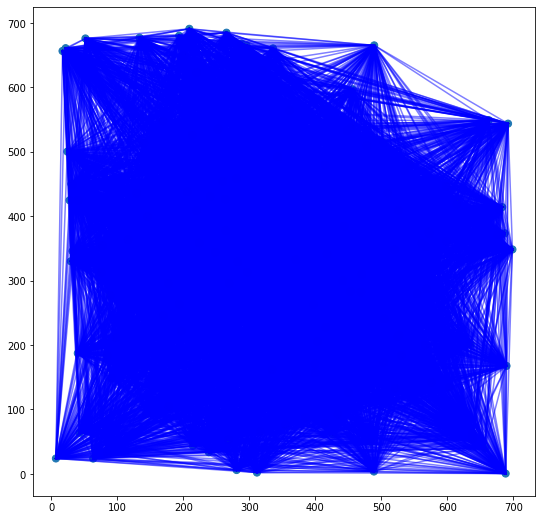

In [6]:
#coords, W_np = get_graph_mat()
plot_graph(cord)

## Define the state
We now define the state tuple, containing a graph (given by a weights matrix `W`), the noode coordinates `coords` and the partial solution (list of visited nodes).
We also define the function `state2tens`, which translates such tuples into tensors (partially loosing the sequence order information).

In [7]:
State = namedtuple('State', ('W', 'coords', 'partial_solution'))
  
def state2tens(state):
    """ Creates a Pytorch tensor representing the history of visited nodes, from a (single) state tuple.
        
        Returns a (Nx5) tensor, where for each node we store whether this node is in the sequence,
        whether it is first or last, and its (x,y) coordinates.
    """
    solution = set(state.partial_solution)
    sol_last_node = state.partial_solution[-1] if len(state.partial_solution) > 0 else -1
    sol_first_node = state.partial_solution[0] if len(state.partial_solution) > 0 else -1
    coords = state.coords
    nr_nodes = coords.shape[0]

    xv = [[(1 if i in solution else 0),
           (1 if i == sol_first_node else 0),
           (1 if i == sol_last_node else 0),
           coords[i,0],
           coords[i,1]
          ] for i in range(nr_nodes)]
    
    return torch.tensor(xv, dtype=torch.float32, requires_grad=False, device=device)

## The Q-Function
Below, we write the neural network that will parameterize the function Q(s, a).

In [8]:
class QNet(nn.Module):
    """ The neural net that will parameterize the function Q(s, a)
    
        The input is the state (containing the graph and visited nodes),
        and the output is a vector of size N containing Q(s, a) for each of the N actions a.
    """    
    
    def __init__(self, emb_dim, T=4):
        """ emb_dim: embedding dimension p
            T: number of iterations for the graph embedding
        """
        super(QNet, self).__init__()
        self.emb_dim = emb_dim
        self.T = T
        
        # We use 5 dimensions for representing the nodes' states:
        # * A binary variable indicating whether the node has been visited
        # * A binary variable indicating whether the node is the first of the visited sequence
        # * A binary variable indicating whether the node is the last of the visited sequence
        # * The (x, y) coordinates of the node.
        self.node_dim = 5
        
        # We can have an extra layer after theta_1 (for the sake of example to make the network deeper)
        nr_extra_layers_1 = 1
        
        # Build the learnable affine maps:
        self.theta1 = nn.Linear(self.node_dim, self.emb_dim, True)
        self.theta2 = nn.Linear(self.emb_dim, self.emb_dim, True)
        self.theta3 = nn.Linear(self.emb_dim, self.emb_dim, True)
        self.theta4 = nn.Linear(1, self.emb_dim, True)
        self.theta5 = nn.Linear(2*self.emb_dim, 1, True)
        self.theta6 = nn.Linear(self.emb_dim, self.emb_dim, True)
        self.theta7 = nn.Linear(self.emb_dim, self.emb_dim, True)
        
        self.theta1_extras = [nn.Linear(self.emb_dim, self.emb_dim, True) for _ in range(nr_extra_layers_1)]
        
    def forward(self, xv, Ws):
        # xv: The node features (batch_size, num_nodes, node_dim)
        # Ws: The graphs (batch_size, num_nodes, num_nodes)
        
        num_nodes = xv.shape[1]
        batch_size = xv.shape[0]
        
        # pre-compute 1-0 connection matrices masks (batch_size, num_nodes, num_nodes)
        conn_matrices = torch.where(Ws > 0, torch.ones_like(Ws), torch.zeros_like(Ws)).to(device)
        
        # Graph embedding
        # Note: we first compute s1 and s3 once, as they are not dependent on mu
        mu = torch.zeros(batch_size, num_nodes, self.emb_dim, device=device)
        s1 = self.theta1(xv)  # (batch_size, num_nodes, emb_dim)
        for layer in self.theta1_extras:
            s1 = layer(F.relu(s1))  # we apply the extra layer
        
        s3_1 = F.relu(self.theta4(Ws.unsqueeze(3)))  # (batch_size, nr_nodes, nr_nodes, emb_dim) - each "weigth" is a p-dim vector        
        s3_2 = torch.sum(s3_1, dim=1)  # (batch_size, nr_nodes, emb_dim) - the embedding for each node
        s3 = self.theta3(s3_2)  # (batch_size, nr_nodes, emb_dim)
        
        for t in range(self.T):
            s2 = self.theta2(conn_matrices.matmul(mu))    
            mu = F.relu(s1 + s2 + s3)
            
        """ prediction
        """
        # we repeat the global state (summed over nodes) for each node, 
        # in order to concatenate it to local states later
        global_state = self.theta6(torch.sum(mu, dim=1, keepdim=True).repeat(1, num_nodes, 1))
        
        local_action = self.theta7(mu)  # (batch_dim, nr_nodes, emb_dim)
            
        out = F.relu(torch.cat([global_state, local_action], dim=2))
        return self.theta5(out).squeeze(dim=2)

In [9]:
""" See what the model returns
"""
model = QNet(3, T=1).to(device)
#coords, W_np = get_graph_mat(n=10)
W = torch.tensor(matrix, dtype=torch.float32, device=device)
xv = torch.rand((1, W.shape[0], 5)).to(device) # random node state
Ws = W.unsqueeze(0)

y = model(xv, Ws)
print('model output: {}'.format(y))

model output: tensor([[-63682.8906, -63672.2578, -63689.1641, -63674.9805, -63716.9883,
         -63731.5781, -63720.0547, -63687.1836, -63730.8398, -63719.1016,
         -63717.4023, -63692.5859, -63720.2969, -63717.6328, -63680.0039,
         -63698.0039, -63671.6211, -63681.9336, -63677.4141, -63675.1328,
         -63687.4180, -63689.2031, -63695.8164, -63679.5352, -63713.0938,
         -63713.6367, -63674.7734, -63722.2539, -63683.9688, -63705.0898,
         -63672.1875, -63717.0000, -63689.7773, -63673.8359, -63671.5547,
         -63717.7344, -63688.2109, -63682.5273, -63683.3789, -63690.8398,
         -63683.7539, -63685.9062, -63684.2930, -63685.6562, -63701.3008,
         -63675.6094, -63690.9062, -63713.8008, -63694.7422, -63675.4414,
         -63693.8438, -63725.1484, -63692.2383, -63670.0977, -63702.2188,
         -63720.9727, -63729.5625, -63693.4570, -63711.6367, -63696.5547,
         -63713.8906, -63702.8867, -63701.3242, -63736.0469, -63713.0312,
         -63755.6992, -6

### A wrapper around the neural net
Below, we define the class `QFunction`, which will act as a wrapper around the neural net `QNet`, and can manipulate TSP (partial) solutions and translate them to tensors.

In [10]:
class QFunction():
    def __init__(self, model, optimizer, lr_scheduler):
        self.model = model  # The actual QNet
        self.optimizer = optimizer
        self.lr_scheduler = lr_scheduler
        self.loss_fn = nn.MSELoss()
    
    def predict(self, state_tsr, W):
        # batch of 1 - only called at inference time
        with torch.no_grad():
            estimated_rewards = self.model(state_tsr.unsqueeze(0), W.unsqueeze(0))
        return estimated_rewards[0]
                
    def get_best_action(self, state_tsr, state):
        """ Computes the best (greedy) action to take from a given state
            Returns a tuple containing the ID of the next node and the corresponding estimated reward
        """
        W = state.W
        estimated_rewards = self.predict(state_tsr, W)  # size (nr_nodes,)
        sorted_reward_idx = estimated_rewards.argsort(descending=True)
        
        solution = state.partial_solution
        
        already_in = set(solution)
        for idx in sorted_reward_idx.tolist():
            if (len(solution) == 0 or W[solution[-1], idx] > 0) and idx not in already_in:
                return idx, estimated_rewards[idx].item()
        
    def batch_update(self, states_tsrs, Ws, actions, targets):
        """ Take a gradient step using the loss computed on a batch of (states, Ws, actions, targets)
        
            states_tsrs: list of (single) state tensors
            Ws: list of W tensors
            actions: list of actions taken
            targets: list of targets (resulting estimated rewards after taking the actions)
        """        
        Ws_tsr = torch.stack(Ws).to(device)
        xv = torch.stack(states_tsrs).to(device)
        self.optimizer.zero_grad()
        
        # the rewards estimated by Q for the given actions
        estimated_rewards = self.model(xv, Ws_tsr)[range(len(actions)), actions]
        
        loss = self.loss_fn(estimated_rewards, torch.tensor(targets, device=device))
        loss_val = loss.item()
        
        loss.backward()
        self.optimizer.step()        
        self.lr_scheduler.step()
        
        return loss_val

## Define experiences & memory
We'll now a tuple representing an experience, and the memory that contains such experiences.
An experience is composed of a (state, action) tuple, and the corresponding "next state" and reward. The "next state" can be N step after the "state" in the case of N-step Q-learning. In experiences, we save states both in their tuple and tensor representations, in order to avoid computing these somewhat expensive translations after the experience has been stored.

The `Memory` class implements a memory of limited size.

In [11]:
# Note: we store state tensors in experience to compute these tensors only once later on
Experience = namedtuple('Experience', ('state', 'state_tsr', 'action', 'reward', 'next_state', 'next_state_tsr'))

class Memory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        self.nr_inserts = 0
        
    def remember(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = experience
        self.position = (self.position + 1) % self.capacity
        self.nr_inserts += 1
        
    def sample_batch(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return min(self.nr_inserts, self.capacity)

## Other useful things
Below, we'll write a few more helper functions for computing solution length, deciding if a state is final and getting a next node at random from the graph.

In [12]:
def total_distance(solution, W):
    if len(solution) < 2:
        return 0  # there is no travel
    
    total_dist = 0
    for i in range(len(solution) - 1):
        total_dist += W[solution[i], solution[i+1]].item()
        
    # if this solution is "complete", go back to initial point
    if len(solution) == W.shape[0]:
        total_dist += W[solution[-1], solution[0]].item()

    return total_dist
        
def is_state_final(state):
    return len(set(state.partial_solution)) == state.W.shape[0]

def get_next_neighbor_random(state):
    solution, W = state.partial_solution, state.W
    
    if len(solution) == 0:
        return random.choice(range(W.shape[0]))
    already_in = set(solution)
    candidates = list(filter(lambda n: n.item() not in already_in, W[solution[-1]].nonzero()))
    if len(candidates) == 0:
        return None
    return random.choice(candidates).item()

## Training Code
### Hyper-parameters

In [13]:
SEED = 101  # A seed for the random number generator

# Graph
NR_NODES = 130  # Number of nodes N
EMBEDDING_DIMENSIONS = 5  # Embedding dimension D
EMBEDDING_ITERATIONS_T = 1  # Number of embedding iterations T

# Learning
NR_EPISODES = 100
MEMORY_CAPACITY = 16000
N_STEP_QL = 2  # Number of steps (n) in n-step Q-learning to wait before computing target reward estimate
BATCH_SIZE = 16

GAMMA = 0.9
INIT_LR = 0.005
LR_DECAY_RATE = 1. - 2e-4  # learning rate decay

MIN_EPSILON = 0.1
EPSILON_DECAY_RATE = 6e-3  # epsilon decay

FOLDER_NAME = './models'  # where to checkpoint the best models

### Model Initialization & checkpointing
We will save our best models over the course of training - here we just define two functions for loading and checkpointing models

In [14]:
def init_model(fname=None):
    """ Create a new model. If fname is defined, load the model from the specified file.
    """
    Q_net = QNet(EMBEDDING_DIMENSIONS, T=EMBEDDING_ITERATIONS_T).to(device)
    optimizer = optim.Adam(Q_net.parameters(), lr=INIT_LR)
    lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=LR_DECAY_RATE)
    
    if fname is not None:
        checkpoint = torch.load(fname)
        Q_net.load_state_dict(checkpoint['model'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
    
    Q_func = QFunction(Q_net, optimizer, lr_scheduler)
    return Q_func, Q_net, optimizer, lr_scheduler

def checkpoint_model(model, optimizer, lr_scheduler, loss, 
                     episode, avg_length):
    if not os.path.exists(FOLDER_NAME):
        os.makedirs(FOLDER_NAME)
    
    fname = os.path.join(FOLDER_NAME, 'ep_{}'.format(episode))
    fname += '_length_{}'.format(avg_length)
    fname += '.tar'
    
    torch.save({
        'episode': episode,
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'lr_scheduler': lr_scheduler.state_dict(),
        'loss': loss,
        'avg_length': avg_length
    }, fname)

### Training Loop
The code below is slightly more complex than the version appearing in the blog article. Notably, here in several places we maintain states represented both as tuples and tensors. We cache the tensor versions in order to avoid re-computing them many times. Also different from the article, the version below implements a version of n-step Q-learning, it checkpoints the best models (according to the median path length), and prints some information.

In [15]:
# seed everything for reproducible results first:
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Create module, optimizer, LR scheduler, and Q-function
Q_func, Q_net, optimizer, lr_scheduler = init_model()

# Create memory
memory = Memory(MEMORY_CAPACITY)

# Storing metrics about training:
found_solutions = dict()  # episode --> (coords, W, solution)
losses = []
path_lengths = []

# keep track of median path length for model checkpointing
current_min_med_length = float('inf')

for episode in range(NR_EPISODES):
    # sample a new random graph
    #coords, W_np = get_graph_mat(n=NR_NODES)
    coords, W_np = cord, matrix
    W = torch.tensor(W_np, dtype=torch.float32, requires_grad=False, device=device)
    
    # current partial solution - a list of node index
    solution = [random.randint(0, NR_NODES-1)]
    
    # current state (tuple and tensor)
    current_state = State(partial_solution=solution, W=W, coords=coords)
    current_state_tsr = state2tens(current_state)
    
    # Keep track of some variables for insertion in replay memory:
    states = [current_state]
    states_tsrs = [current_state_tsr]  # we also keep the state tensors here (for efficiency)
    rewards = []
    actions = []
    
    # current value of epsilon
    epsilon = max(MIN_EPSILON, (1-EPSILON_DECAY_RATE)**episode)
    
    nr_explores = 0
    t = -1
    while not is_state_final(current_state):
        t += 1  # time step of this episode
        
        if epsilon >= random.random():
            # explore
            next_node = get_next_neighbor_random(current_state)
            nr_explores += 1
        else:
            # exploit
            next_node, est_reward = Q_func.get_best_action(current_state_tsr, current_state)
            if episode % 50 == 0:
                print('Ep {} | current sol: {} / next est reward: {}'.format(episode, solution, est_reward))
        
        next_solution = solution + [next_node]
        
        # reward observed for taking this step        
        reward = -(total_distance(next_solution, W) - total_distance(solution, W))
        
        next_state = State(partial_solution=next_solution, W=W, coords=coords)
        next_state_tsr = state2tens(next_state)
        
        # store rewards and states obtained along this episode:
        states.append(next_state)
        states_tsrs.append(next_state_tsr)
        rewards.append(reward)
        actions.append(next_node)
        
        # store our experience in memory, using n-step Q-learning:
        if len(solution) >= N_STEP_QL:
            memory.remember(Experience(state=states[-N_STEP_QL],
                                       state_tsr=states_tsrs[-N_STEP_QL],
                                       action=actions[-N_STEP_QL],
                                       reward=sum(rewards[-N_STEP_QL:]),
                                       next_state=next_state,
                                       next_state_tsr=next_state_tsr))
            
        if is_state_final(next_state):
            for n in range(1, N_STEP_QL):
                memory.remember(Experience(state=states[-n],
                                           state_tsr=states_tsrs[-n], 
                                           action=actions[-n], 
                                           reward=sum(rewards[-n:]), 
                                           next_state=next_state,
                                           next_state_tsr=next_state_tsr))
        
        # update state and current solution
        current_state = next_state
        current_state_tsr = next_state_tsr
        solution = next_solution
        
        # take a gradient step
        loss = None
        if len(memory) >= BATCH_SIZE and len(memory) >= 2000:
            experiences = memory.sample_batch(BATCH_SIZE)
            
            batch_states_tsrs = [e.state_tsr for e in experiences]
            batch_Ws = [e.state.W for e in experiences]
            batch_actions = [e.action for e in experiences]
            batch_targets = []
            
            for i, experience in enumerate(experiences):
                target = experience.reward
                if not is_state_final(experience.next_state):
                    _, best_reward = Q_func.get_best_action(experience.next_state_tsr, 
                                                            experience.next_state)
                    target += GAMMA * best_reward
                batch_targets.append(target)
                
            # print('batch targets: {}'.format(batch_targets))
            loss = Q_func.batch_update(batch_states_tsrs, batch_Ws, batch_actions, batch_targets)
            losses.append(loss)
            
            """ Save model when we reach a new low average path length
            """
            med_length = np.median(path_lengths[-100:])
            if med_length < current_min_med_length:
                current_min_med_length = med_length
                checkpoint_model(Q_net, optimizer, lr_scheduler, loss, episode, med_length)
                
    length = total_distance(solution, W)
    path_lengths.append(length)

    if episode % 10 == 0:
        print('Ep %d. Loss = %.3f / mean length = %.3f / best = %.4f / epsilon = %.4f / lr = %.4f' % (
            episode, (-1 if loss is None else loss), np.mean(path_lengths), np.min(path_lengths), epsilon,
            Q_func.optimizer.param_groups[0]['lr']))
        found_solutions[episode] = (W.clone(), coords.copy(), [n for n in solution])

Ep 0. Loss = -1.000 / mean length = 45520.323 / best = 45520.3233 / epsilon = 1.0000 / lr = 0.0050
Ep 10. Loss = -1.000 / mean length = 45614.380 / best = 42871.7190 / epsilon = 0.9416 / lr = 0.0050
Ep 20. Loss = 256848.938 / mean length = 46363.997 / best = 42871.7190 / epsilon = 0.8866 / lr = 0.0043
Ep 30. Loss = 179781.094 / mean length = 46204.118 / best = 42347.2930 / epsilon = 0.8348 / lr = 0.0034
Ep 40. Loss = 140189.734 / mean length = 46365.870 / best = 42347.2930 / epsilon = 0.7861 / lr = 0.0026
Ep 50 | current sol: [39] / next est reward: -2224.815673828125
Ep 50 | current sol: [39, 53, 96, 86, 89] / next est reward: -2195.598388671875
Ep 50 | current sol: [39, 53, 96, 86, 89, 34] / next est reward: -2196.31494140625
Ep 50 | current sol: [39, 53, 96, 86, 89, 34, 16, 68] / next est reward: -2234.635498046875
Ep 50 | current sol: [39, 53, 96, 86, 89, 34, 16, 68, 30, 47, 17, 18, 20, 66, 56] / next est reward: -2382.44677734375
Ep 50 | current sol: [39, 53, 96, 86, 89, 34, 16, 6

## Inspect Training Metrics
Let's look at the (moving averages of) loss and path length over training.

Text(0.5, 0, 'episode')

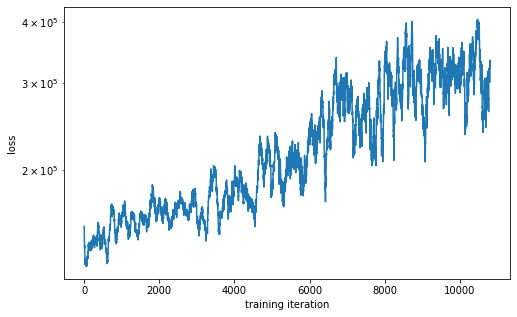

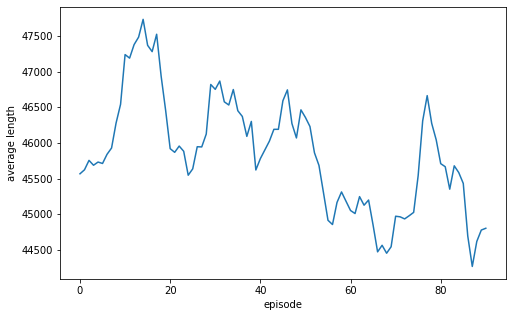

In [16]:
def _moving_avg(x, N=10):
    return np.convolve(np.array(x), np.ones((N,))/N, mode='valid')

plt.figure(figsize=(8,5))
plt.semilogy(_moving_avg(losses, 100))
plt.ylabel('loss')
plt.xlabel('training iteration')

plt.figure(figsize=(8,5))
plt.plot(_moving_avg(path_lengths))
plt.ylabel('average length')
plt.xlabel('episode')

## Re-run Best Model and Look at Paths

In [17]:
""" Get file with smallest distance
"""
all_lengths_fnames = [f for f in os.listdir(FOLDER_NAME) if f.endswith('.tar')]
shortest_fname = sorted(all_lengths_fnames, key=lambda s: float(s.split('.tar')[0].split('_')[-1]))[0]
print('shortest avg length found: {}'.format(shortest_fname.split('.tar')[0].split('_')[-1]))

""" Load checkpoint
"""
Q_func, Q_net, optimizer, lr_scheduler = init_model(os.path.join(FOLDER_NAME, shortest_fname))

""" A function to plot solutions
"""
def plot_solution(coords, mat, solution):
    plt.scatter(coords[:,0], coords[:,1])
    n = len(coords)
    
    for idx in range(n-1):
        i, next_i = solution[idx], solution[idx+1]
        plt.plot([coords[i, 0], coords[next_i, 0]], [coords[i, 1], coords[next_i, 1]], 'k', lw=2, alpha=0.8)
    
    i, next_i = solution[-1], solution[0]
    plt.plot([coords[i, 0], coords[next_i, 0]], [coords[i, 1], coords[next_i, 1]], 'k', lw=2, alpha=0.8)
    plt.plot(coords[solution[0], 0], coords[solution[0], 1], 'x', markersize=10)


    
""" Generate example solutions
"""
# NR_NODES = 10
# for sample in range(10):
#     coords, W_np = get_graph_mat(n=NR_NODES)
#     W = torch.tensor(W_np, dtype=torch.float32, requires_grad=False, device=device)
    
#     solution = [random.randint(0, NR_NODES-1)]
#     current_state = State(partial_solution=solution, W=W, coords=coords)
#     current_state_tsr = state2tens(current_state)
    
#     while not is_state_final(current_state):
#         next_node, est_reward = Q_func.get_best_action(current_state_tsr, 
#                                                        current_state)
        
        
#         solution = solution + [next_node]
#         current_state = State(partial_solution=solution, W=W, coords=coords)
#         current_state_tsr = state2tens(current_state)
        
#     plt.figure()
#     plot_solution(coords, W, solution)
#     plt.title('model / len = {}'.format(total_distance(solution, W)))
    
#     # for comparison, plot a random solution
#     plt.figure()
#     random_solution = list(range(NR_NODES))
#     plot_solution(coords, W, random_solution)
#     plt.title('random / len = {}'.format(total_distance(random_solution, W)))

shortest avg length found: 45736.91802787781


' Generate example solutions\n'

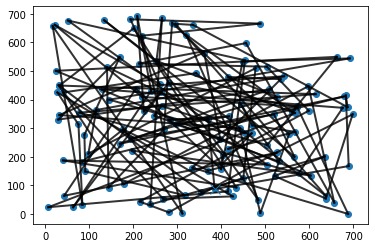

In [18]:
plot_solution(cord,matrix,solution)

In [19]:
sol = '''1
41
39
117
112
115
28
62
105
128
16
45
5
11
76
109
61
129
124
64
69
86
88
26
7
97
70
107
127
104
43
34
17
31
27
19
100
15
29
24
116
95
79
87
12
81
103
77
94
89
110
98
68
63
48
25
113
32
36
84
119
111
123
101
82
57
9
56
65
52
75
74
99
73
92
38
106
53
120
58
49
72
91
6
102
10
14
67
13
96
122
55
60
51
42
44
93
37
22
47
40
23
33
21
126
121
78
66
85
125
90
59
30
83
3
114
108
8
18
46
80
118
20
4
35
54
2
50
130
71'''

In [20]:
sols = list(map(lambda x: int(x) - 1,sol.split('\n')))

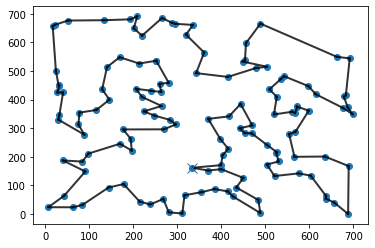

In [21]:
plot_solution(cord,matrix,sols)

In [22]:
len(sols)

130